In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a505eeb10>,
      dtype=object)

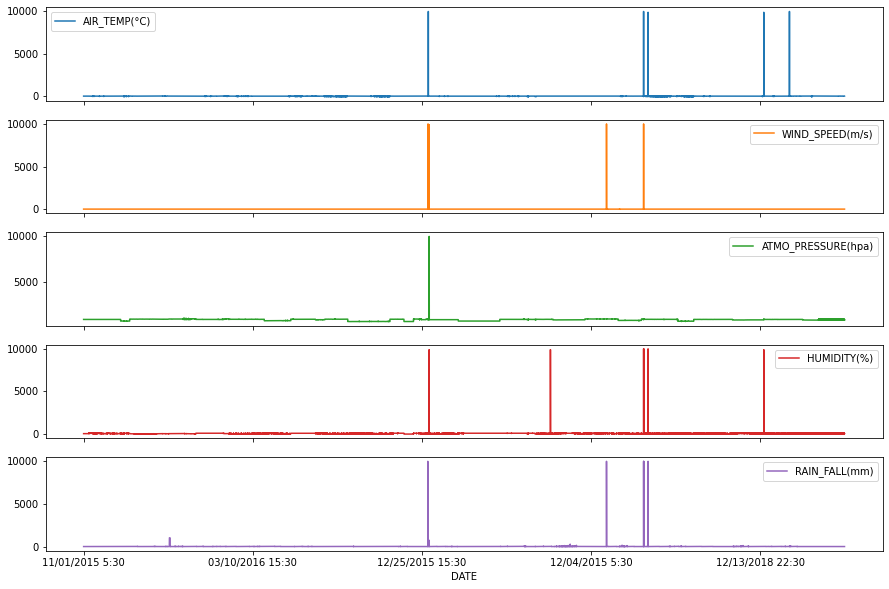

In [ ]:
df = pd.read_csv(root+'himachal_pradesh_isro.csv')
df['DATE'] = df['DATE(IST)'] + " " + df['TIME(IST)']
df.drop(columns=['@STATION_ID', 'ALTITUDE(m)', 'WIND_DIRECTION(deg)', 'SUN_SHINE(hh:mm)','BATTERY_VOLTAGE(V)','TIME(GMT)', 'DATE(GMT)', 'TIME(IST)', 'DATE(IST)', 'LATITUDE', 'LONGITUDE'])
df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a5dd03250>,
      dtype=object)

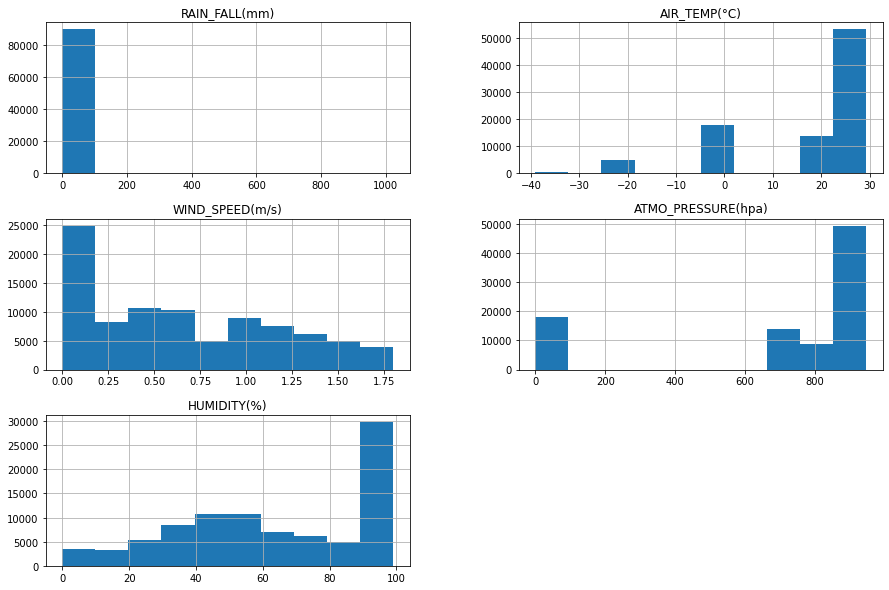

In [ ]:
df_input=df[['RAIN_FALL(mm)','AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)']]
for i in df_input.columns:
  if(i == 'RAIN_FALL(mm)'):
    a = df_input[i] > 2000
    df_input[i][a] = 0
  elif (i == 'DATE'):
    continue
  else:
    a = df_input[i].quantile(0.80)
    b = df_input[i] > a
    df_input[i][b] = 0
df_input.hist(figsize = (15, 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a506d5710>,
      dtype=object)

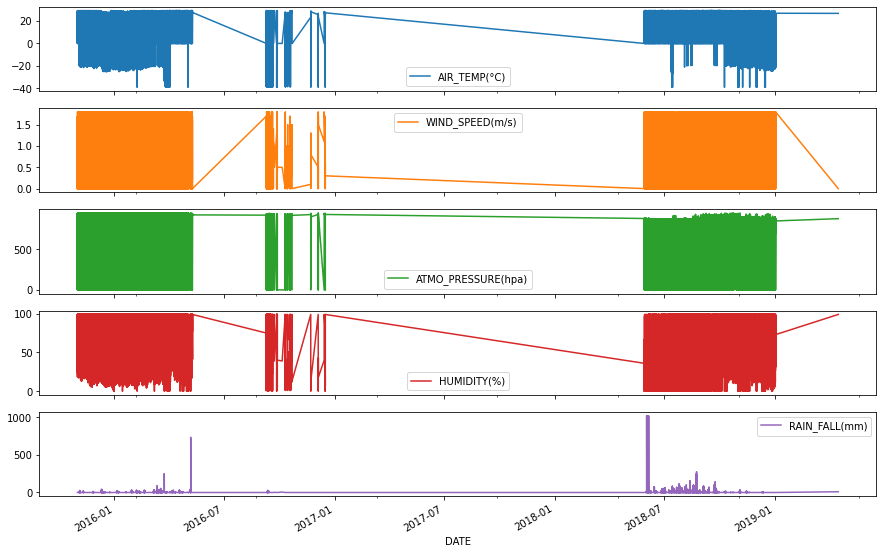

In [ ]:
df_input['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y %H:%M")
df_input.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True, figsize=(15, 10))

In [ ]:
df_input.to_csv(root+'corrected/himachal_pradesh.csv', header=True, index=False)
df_input.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,89934.000000,89934.000000,89934.000000,89934.000000,89934.000000
mean,2.034125,17.232273,0.635450,694.582588,64.356439
std,31.248595,14.094944,0.540336,353.946923,29.728703
min,0.000000,-39.100000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.100000,701.900000,42.000000
50%,0.000000,23.700000,0.600000,873.100000,64.000000
75%,0.000000,26.300000,1.000000,926.400000,99.000000
max,1023.000000,29.300000,1.800000,945.900000,99.000000


## Data split
Split the data into training and test set 

In [ ]:
datelist = df_input['DATE']
print(datelist)
df_input = df_input.drop('DATE', 1)
training_set = df_input

0       2015-11-01 05:30:00
1       2015-11-01 06:30:00
2       2015-11-01 07:30:00
3       2015-11-01 08:30:00
4       2015-11-01 09:30:00
                ...        
89929   2019-01-02 06:30:00
89930   2019-01-02 07:30:00
89931   2019-01-02 08:30:00
89932   2019-01-02 09:30:00
89933   2019-01-02 10:30:00
Name: DATE, Length: 89934, dtype: datetime64[ns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:, 1:2])

array([[0.56529288],
       [0.57238766],
       [0.55110332],
       ...,
       [0.6362407 ],
       [0.65043026],
       [0.68590417]])

In [ ]:
X_train = []
y_train = []

n_future = 90   # Number of observations we want top predict into the future
n_past = 60     # Number of past observations we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 1])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (89785, 60, 5).
y_train shape == (89785, 1).


In [ ]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_input.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,), loss='mean_squared_error')

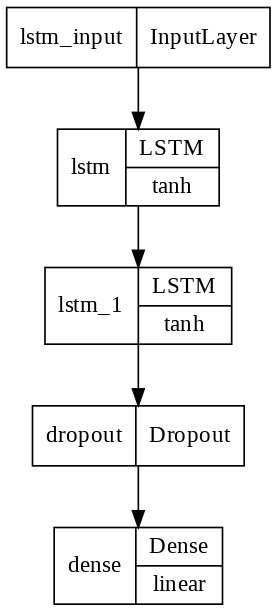

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file=root + "temp_hp_week5lstm.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=120,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath= root+'temp_hp_week5_lstm_isro.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=12, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/12
281/281 [==============================] - ETA: 0s - loss: 0.6593
Epoch 1: val_loss improved from inf to 0.50988, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/temp_hp_week5_lstm_isro.h5
281/281 [==============================] - 18s 37ms/step - loss: 0.6593 - val_loss: 0.5099 - lr: 0.0100
Epoch 2/12
281/281 [==============================] - ETA: 0s - loss: 0.6421
Epoch 2: val_loss improved from 0.50988 to 0.47518, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/temp_hp_week5_lstm_isro.h5
281/281 [==============================] - 9s 32ms/step - loss: 0.6421 - val_loss: 0.4752 - lr: 0.0100
Epoch 3/12
281/281 [==============================] - ETA: 0s - loss: 0.6102
Epoch 3: val_loss did not improve from 0.47518
281/281 [==============================] - 9s 32ms/step - loss: 0.6102 - val_loss: 0.5292 - lr: 0.0100
Epoch 4/12
281/281 [==============================] - ETA: 0s - loss: 0.58

In [ ]:
datelist_future = pd.date_range(datelist.iloc[-1], periods=15000, freq='3h').tolist()
predictions_future = model.predict(X_train[-15000:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Air Temp (°C)']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Air Temp (°C)']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
PREDICTION_TRAIN.head(3)

,Air Temp (°C)
DATE,
2015-11-10 04:30:00,23.172020
2015-11-10 05:30:00,23.273190
2015-11-10 06:30:00,23.533218


In [ ]:
df_input['DATE'] = datelist

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


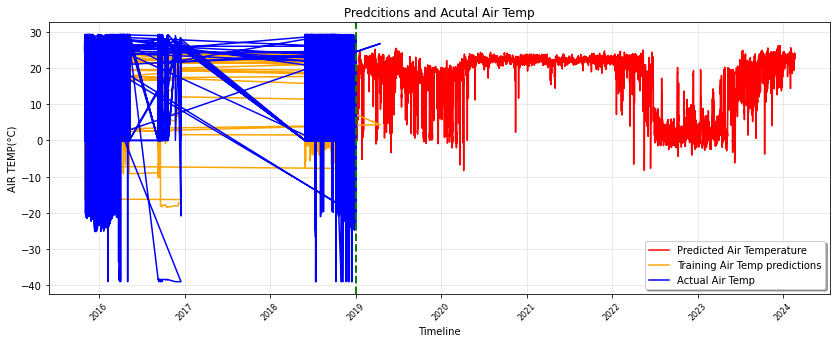

In [ ]:
plt.rcParams['figure.figsize'] = 14, 5

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Air Temp (°C)'], color='r', label='Predicted Air Temperature')
plt.plot(PREDICTION_TRAIN.iloc[0:].index, PREDICTION_TRAIN.iloc[0:]['Air Temp (°C)'], color='orange', label='Training Air Temp predictions')
plt.plot(df_input.iloc[0:]['DATE'], df_input.iloc[0:]['AIR_TEMP(°C)'], color='b', label='Actual Air Temp')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Air Temp', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('AIR TEMP(°C)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()